In [ ]:
import pandas as pd

# Read in track metadata with genre labels
tracks = pd.read_csv('https://raw.githubusercontent.com/hskhawaja/Datacamp-Projects/master/Classify%20Song%20Genres%20from%20Audio%20Data/datasets/fma-rock-vs-hiphop.csv')

# Read in track metrics with the features
echonest_metrics = pd.read_json('https://raw.githubusercontent.com/hskhawaja/Datacamp-Projects/master/Classify%20Song%20Genres%20from%20Audio%20Data/datasets/echonest-metrics.json',precise_float=True)

# Merge the relevant columns of tracks and echonest_metrics
echo_tracks = echonest_metrics.merge(tracks[['genre_top', 'track_id']], on='track_id')
# Inspect the resultant dataframe
echo_tracks.info()

# Pairwise relationships between continuous variables
We typically want to avoid using variables that have strong correlations with each other -- hence avoiding feature redundancy

In [7]:
# Create a correlation matrix
corr_metrics = echo_tracks.corr()
corr_metrics.style.background_gradient()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,1.000000,-0.372282,0.049454,0.140703,-0.275623,0.048231,-0.026995,-0.025392,0.010070
acousticness,-0.372282,1.000000,-0.028954,-0.281619,0.194780,-0.019991,0.072204,-0.026310,-0.013841
danceability,0.049454,-0.028954,1.000000,-0.242032,-0.255217,-0.106584,0.276206,-0.242089,0.473165
energy,0.140703,-0.281619,-0.242032,1.000000,0.028238,0.113331,-0.109983,0.195227,0.038603
instrumentalness,-0.275623,0.194780,-0.255217,0.028238,1.000000,-0.091022,-0.366762,0.022215,-0.219967
liveness,0.048231,-0.019991,-0.106584,0.113331,-0.091022,1.000000,0.041173,0.002732,-0.045093
speechiness,-0.026995,0.072204,0.276206,-0.109983,-0.366762,0.041173,1.000000,0.008241,0.149894
tempo,-0.025392,-0.026310,-0.242089,0.195227,0.022215,0.002732,0.008241,1.000000,0.052221
valence,0.010070,-0.013841,0.473165,0.038603,-0.219967,-0.045093,0.149894,0.052221,1.000000


# Splitting our data 


In [12]:
# Import train_test_split function and Decision tree classifier
# ... YOUR CODE ...
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
# Create features
features = echo_tracks.drop(['genre_top','track_id'],axis=1).values

# Create labels
labels = echo_tracks["genre_top"].values

# Split our data
train_features, test_features, train_labels, test_labels = train_test_split(features,labels,random_state=10)


# Normalizing the feature data

In [13]:
# Import the StandardScaler
from sklearn.preprocessing import StandardScaler

# Scale the features and set the values to a new variable
scaler = StandardScaler()

# Scale train_features and test_features
scaled_train_features = scaler.fit_transform(train_features)
scaled_test_features = scaler.transform(test_features)

# Principal Component Analysis on our scaled data

Text(0.5, 0, 'Principal Component #')

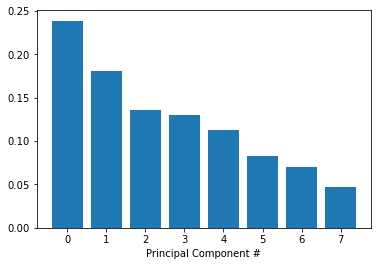

In [14]:
# This is just to make plots appear in the notebook
%matplotlib inline

# Import our plotting module, and PCA class
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Get our explained variance ratios from PCA using all features
pca = PCA()
pca.fit(scaled_train_features)
exp_variance = pca.explained_variance_ratio_

# plot the explained variance using a barplot
fig, ax = plt.subplots()
ax.bar(range(pca.n_components_), exp_variance)
ax.set_xlabel('Principal Component #')

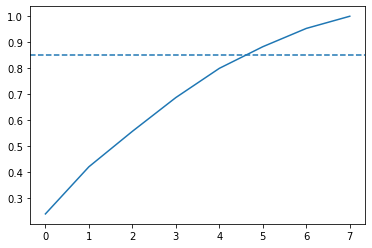

In [15]:
# Import numpy
import numpy as np

# Calculate the cumulative explained variance
cum_exp_variance = np.cumsum(exp_variance)

# Plot the cumulative explained variance and draw a dashed line at 0.85.
fig, ax = plt.subplots()
ax.plot(cum_exp_variance)
ax.axhline(y=0.85, linestyle='--')

# Projecting on to our features

In [16]:
# Perform PCA with the chosen number of components and project data onto components
pca = PCA(n_components=6,random_state=10)

# Fit and transform the scaled training features using pca
train_pca = pca.fit_transform(scaled_train_features)

# Fit and transform the scaled test features using pca
test_pca = pca.transform(scaled_test_features)

# Train a decision tree to classify genre

In [17]:
# Import Decision tree classifier
# ... YOUR CODE ...
from sklearn.tree import DecisionTreeClassifier

# Train our decision tree
tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_pca,train_labels)

# Predict the labels for the test data
pred_labels_tree = tree.predict(test_pca)

# Compare our decision tree to a logistic regression

In [18]:
# Import LogisticRegression
from sklearn.linear_model import LogisticRegression

# Train our logistic regression and predict labels for the test set
logreg = LogisticRegression(random_state=10)
logreg.fit(train_pca,train_labels)
pred_labels_logit = logreg.predict(test_pca)

# Create the classification report for both models
from sklearn.metrics import classification_report
class_rep_tree = classification_report(test_labels,pred_labels_tree)
class_rep_log = classification_report(test_labels,pred_labels_logit)

print("Decision Tree: \n", class_rep_tree)
print("Logistic Regression: \n", class_rep_log)

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.63      0.62      0.62       235
        Rock       0.91      0.91      0.91       966

    accuracy                           0.85      1201
   macro avg       0.77      0.77      0.77      1201
weighted avg       0.85      0.85      0.85      1201

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.77      0.54      0.64       235
        Rock       0.90      0.96      0.93       966

    accuracy                           0.88      1201
   macro avg       0.83      0.75      0.78      1201
weighted avg       0.87      0.88      0.87      1201



# Balance our data for greater performance

In [19]:
# Subset a balanced proportion of data points
hop_only = echo_tracks.loc[echo_tracks['genre_top'] == 'Hip-Hop']
rock_only = echo_tracks.loc[echo_tracks['genre_top'] == 'Rock']

# subset only the rock songs, and take a sample the same size as there are hip-hop songs
rock_only = rock_only.sample(hop_only.shape[0], random_state=10)

# concatenate the dataframes hop_only and rock_only
rock_hop_bal = pd.concat([rock_only, hop_only])

# The features, labels, and pca projection are created for the balanced dataframe
features = rock_hop_bal.drop(['genre_top', 'track_id'], axis=1) 
labels = rock_hop_bal['genre_top']

# Redefine the train and test set with the pca_projection from the balanced data
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, random_state=10)

train_pca = pca.fit_transform(scaler.fit_transform(train_features))
test_pca = pca.transform(scaler.transform(test_features))

#  Does balancing our dataset improve model bias?

In [21]:
# Train our decision tree on the balanced data
tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_pca, train_labels)
pred_labels_tree = tree.predict(test_pca)

# Train our logistic regression on the balanced data
logreg = LogisticRegression(random_state=10)
logreg.fit(train_pca, train_labels)
pred_labels_logit = logreg.predict(test_pca)

# compare the models
print("Decision Tree: \n", classification_report(test_labels, pred_labels_tree))
print("Logistic Regression: \n", classification_report(test_labels, pred_labels_logit))

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.82      0.77      0.79       230
        Rock       0.78      0.82      0.80       225

    accuracy                           0.80       455
   macro avg       0.80      0.80      0.80       455
weighted avg       0.80      0.80      0.80       455

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.84      0.80      0.82       230
        Rock       0.81      0.85      0.83       225

    accuracy                           0.82       455
   macro avg       0.82      0.82      0.82       455
weighted avg       0.83      0.82      0.82       455



# Using cross-validation to evaluate our models

In [26]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
tree_pipe = Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=6)), 
                      ("tree", DecisionTreeClassifier(random_state=10))])
logreg_pipe = Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=6)), 
                        ("logreg", LogisticRegression(random_state=10))])

# Set up our K-fold cross-validation
kf = KFold(n_splits=10)

# Train our models using KFold cv
tree_score = cross_val_score(tree_pipe, features, labels, cv=kf)
logit_score = cross_val_score(logreg_pipe, features, labels, cv=kf)

# Print the mean of each array of scores
print("Decision Tree:",tree_score, "Logistic Regression:", logit_score)

Decision Tree: [0.73626374 0.75824176 0.7967033  0.75274725 0.75274725 0.74175824
 0.78021978 0.79120879 0.76923077 0.7032967 ] Logistic Regression: [0.77472527 0.81318681 0.82967033 0.76923077 0.75824176 0.78021978
 0.77472527 0.74175824 0.7967033  0.79120879]


In [30]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.metrics import accuracy_score

In [43]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kf, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(train_pca, train_labels)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


C:\ANACONDA\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.8439942  0.84325891 0.83597037 0.84914663 0.83739802 0.84253435
 0.84325354 0.84840597 0.84547016 0.84691391 0.84255045 0.84399957
 0.83959317 0.840307   0.83887398 0.84251825 0.84252362 0.84105839
 0.83886325 0.83739266 0.83960927 0.8403231  0.8410906  0.84255045
 0.84328038 0.84255045 0.84548089 0.8403392  0.84183126 0.84622692
 0.84107986 0.84182052 0.84107986 0.84474023 0.83889545 0.84255045
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan]
  warnings.warn(


0.8491466294547017

In [35]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kf, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(train_pca, train_labels)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


0.8498604551309574

In [37]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kf, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(train_pca, train_labels)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


0.8608308286818376

In [44]:
### Logistic regression 
Lr=LogisticRegression()
lr_param_grid={"C":[0.001, 0.01, 0.1, 1, 10, 100, 1000], "penalty":["l1","l2"]}

gslr = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kf, scoring="accuracy", n_jobs= 4, verbose = 1)

gslr.fit(train_pca, train_labels)

lr_best = gslr.best_estimator_

# Best score
gslr.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


0.8608308286818376

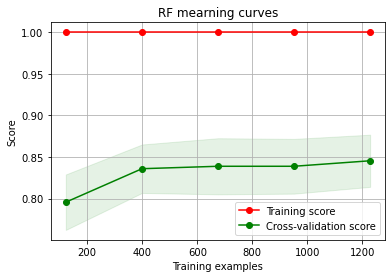

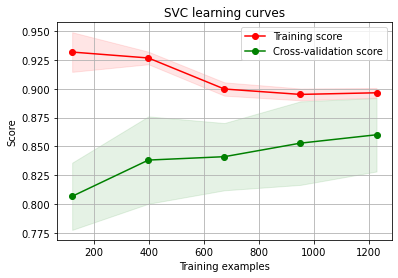

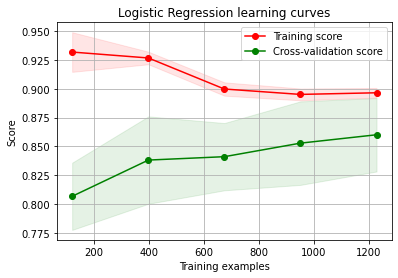

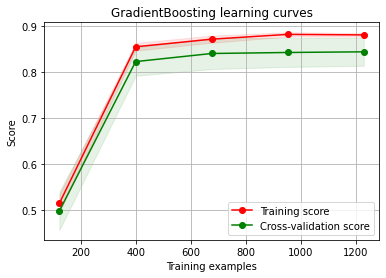

In [45]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",train_pca, train_labels,cv=kf)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",train_pca, train_labels,cv=kf)
g = plot_learning_curve(gslr.best_estimator_,"Logistic Regression learning curves",train_pca, train_labels,cv=kf)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",train_pca, train_labels,cv=kf)

In [46]:
votingC = VotingClassifier(estimators=[('lr', lr_best),('svc', SVMC_best),('gbc',GBC_best)], voting='soft', n_jobs=4)


In [47]:
voting_pipe = Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=6)), 
                      ("voting",votingC)])

In [49]:
Voting_score = cross_val_score(voting_pipe, features, labels, cv=kf)

# Print the mean of each array of scores
print("Voting_score:",Voting_score)

Voting_score: [0.81318681 0.86263736 0.87912088 0.85714286 0.83516484 0.78021978
 0.78571429 0.77472527 0.81868132 0.77472527]
